### Evaluating a neural network for comparison

In [5]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

In [25]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X)))
    ])

In [7]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 221)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.3, random_state=42)

In [18]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation


# Define the build function for the second estimator
def build_nn():
    model = Sequential()
    model.add(Dense(221, kernel_initializer='normal', activation='relu', input_shape=(221,)))
    model.add(Dropout(.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the mode
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [19]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp

plot_callback = lp.PlotLossesKeras()
callbacks = [plot_callback]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=1000, callbacks=callbacks, 
                                     validation_data=(X_test, y_test)))
])

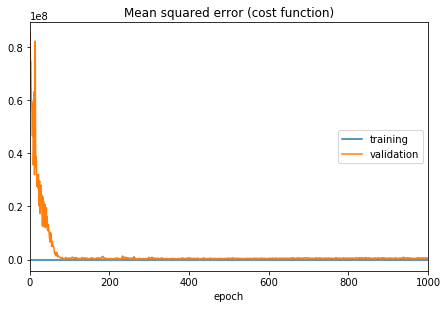

In [20]:
model_info = pipeline.fit(X_train, y_train)

In [21]:
predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, False)

R2-score: 0.848370263597
RMSE (log): 0.14797560563359868


In [29]:
# Now we train and execute the neural network on complete data set
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)


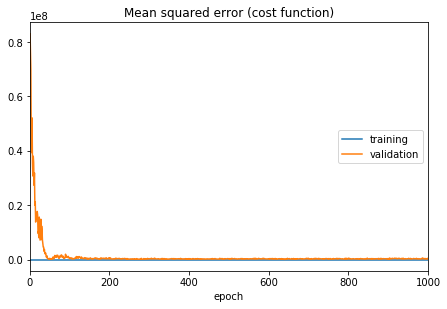

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D9557A25C0>)])

In [30]:
# Fit the network to the complete training data
pipeline.fit(X_train_trans, y_train)

In [36]:
# Predict with the network
predictions = pipeline.predict(X_test_trans)

In [37]:
write_submission(predictions)

File written to C:\Source\predicting-house-prices\submissions\20180824163435.csv


Kaggle: 0.16425